## 結論
OpenAIのGPTモデルでドキュメントを処理する際に、日本語の1文字は大よそ1Tokenに等しいです。千文字のドキュメントを処理するためには、概算で、スピード重視の`gpt-3.5-turbo`を使う場合は0.59円かかります。性能重視の`gpt-4-32k`を利用する場合は、9.7円かかります。

## 目的
GPT3を用いた提案をする際によく聞かれることとしては、コストいくらかのことです。GPT3のAPIの課金は下記のように文字数ではなく、`token`を単位としているため、説明するのは簡単ではないです。

本文は値段の説明をしやすいように、実際のデータで実験してみます。ついてにTicTokenの挙動についても掘り下げてみます。
実験のステップは下記の通りです。  

1. livedoor ニュースコーパスをダウンロードする  
2. ニュースコーパスを`tiktoken`でトークナイズする
3. Token数/文字数で、千文字あたりの値段を計算する

**テキスト補完モデル**
<table style= 'width:100%'>
  <tr>
    <th>モデル名</th>
    <th>値段(**Prompt**)</th>
    <th>値段(**補完**)</th>
    <th>最大トークン数</th>
    <th>モデルサイズ(推測)</th>
  </tr>
  <tr>
    <td>gpt-3.5-turbo</td>
    <td>$0.002</td>
    <td>$0.002</td>
    <td>4,096</td>
    <td>6.7B</td>
  </tr>
  <tr>
    <td>gpt-4</td>
    <td>$0.03</td>
    <td>$0.06</td>
    <td>8,192</td>
    <td>不明</td>
  </tr>
  <tr>
    <td>gpt-4-32k</td>
    <td>$0.06</td>
    <td>$0.12</td>
    <td>32,768</td>
    <td>不明</td>
  </tr>
</table>




## 前準備
GPT3のTokenizerは[`tiktoken`](https://github.com/openai/tiktoken)というライブラリを利用しているので、検証するためには`tiktoken`をインストールする必要があります。

今回利用するデータは、[livedoor ニュースコーパス](https://www.rondhuit.com/download.html)です。livedoor ニュースコーパスは、9つのカテゴリに分類された、記事のデータセットです。

In [1]:
!pip install tiktoken
!curl -O https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar -zxvf ldcc-20140209.tar.gz

次に文字数とトークン数の関係を計算します。

In [1]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import tiktoken

# load data
path_list = glob.glob('./text/*/*.txt')
txt_list =[]
for path in path_list:
    category = path.split('/')[2]
    with open(path) as f:
        # skip first 2 lines
        for i in range(2):
            f.readline()
        txt_list.append(( category, f.read()))
df =  pd.DataFrame( txt_list, columns=['category', 'text'])
df["word_count"] = df["text"].apply(lambda x: len(x))

# cl100k_base is for gpt-4, gpt-3.5-turbo, text-embedding-ada-002
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
encoder = tiktoken.get_encoding("cl100k_base")
df["token_ids"] = df["text"].apply(lambda x: encoder.encode(x))
df["token_count"] = df["token_ids"].apply(lambda x: len(x))
df["tokens"]  = df["token_ids"].apply(lambda x: encoder.decode_tokens_bytes(x))
df["word_token_ratio"] = df["token_count"] / df["word_count"]

## 計算
まず、処理するデータの様子を実際に見てみましょう。

In [2]:
print("ドキュメントのサンプル：")
for i in txt_list[0][1].split('\n')[:10]:
    print(i)
print("...")

ドキュメントのサンプル：
【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か
　2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初の長編サスペンス『八日目の蝉』。2010年に檀れいと北乃きいの出演によりテレビドラマ化された同作が、2011年4月に永作博美と井上真央の出演によって映画化。そして、劇場公開から半年が過ぎた10月28日、DVD＆ブルーレイとなって発売されました。

八日目の蝉
　妻子ある男と愛し合い、その子を身ごもりながら、あきらめざるをえなかった女。彼女は同時に、男の妻が子供を産んだことを知る。その赤ん坊を見に行った女は、突発的にその子を連れ去り、逃避行を続けた挙句、小豆島に落ち着き、母と娘として暮らしはじめる。


不倫相手の子供を誘拐し、4年間育てた女
　永作博美が演じる野々宮希和子は、不倫相手の子を宿しながらも、彼の「いずれ妻と別れるから、それまで待ってくれ」という常套句を信じて、中絶。後遺症により、二度と子供を産めない身体となってしまいます。その後、不倫相手から彼の妻が出産したことを知らされ、別れを決意。最後に諦めをつけるため、彼らの生後6ヶ月の赤ん坊・恵理菜の顔を見た希和子でしたが、自分に笑顔で向けた恵理菜を見て、思わず誘拐。名前を変えて恵理菜を薫と名付けると、人目を避けて各地を転々とし、二人で幸せな時間を過ごしますが、辿り着いた最後の場所・小豆島で4年の逃避行に終止符を打ちます。

...


合計7,376件のドキュメントがあり、平均文字数は1,200文字程度です。

In [3]:
df.word_count.describe().astype(int)

count     7376
mean      1259
std        763
min         37
25%        730
50%       1069
75%       1602
max      12163
Name: word_count, dtype: int64

<span style="background-color: #FFFF00">
文字数とトークン数の割合を見ると、以外に1文字が1トークンになっていることがわかります。
</span>
また、この傾向が記事の種類によりますが、大きな違いはありません。

In [4]:
df.word_token_ratio.mean()

1.008244127016698

<Axes: ylabel='category'>

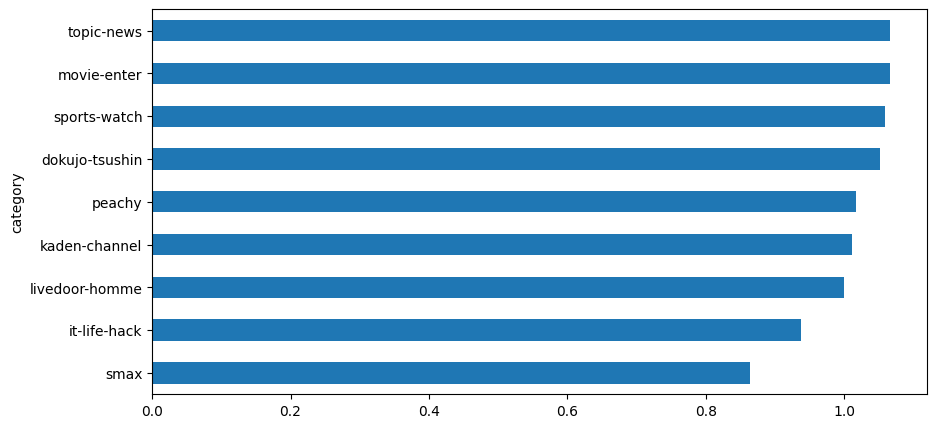

In [5]:
df.groupby("category").word_token_ratio.mean().sort_values().plot.barh(figsize=(10, 5))

これで文字数とトークン数の関係がわかることによって、ドキュメントを処理する課金を概算計算することができます。概算ロジックは以下と仮定します。

-   インプットの長さは2000字とする。内訳は以下の通り。

    -   処理するドキュメントの長さは1000字とする。

    -   タスクの説明や、処理の例は1000字とする。

-   アウトプットは200字とする。

-   為替レートは1ドル=135円とする。

これで計算すると1ドキュメントを処理するためには:

- スピードを求める`gpt-3.5-turbo`の場合は、0.002 * 2200 / 1000 * 135 = 0.59円 かかります。

- 性能を重視する`gpt-4-32k`を利用する場合は(0.03 * 2000 + 0.06 * 200) / 1000 * 135 = 9.7円 かかります。

## TicTokenの挙動

### BPEモデルが違う
日本語は英語よりトークン数が多いと話している投稿は過去Twitterで見たことがあります。今回実際に計算してみると、日本語の1文字は大よそ1Tokenに等しいことがわかりました。それはDecodingするモデルが違うためです。

ここからはちょっと深い話をします。`TikToken`はBPE(Byte Pair Encoding)というデータ圧縮法に基づいて開発しました。コンピューターは文字を扱うことができないので、文字を数値に変換する必要があります。BPEは文字列をシンボルに置き換えることで、文字列を数値に変換します。BPEは頻繁に現れる文字のペアや、複数の文字を組み合わせたシンボルを生成します。それにより、入力するシーケンスの長さを短くすることができます。

例えば、"ab ab b"の文字列について、"ab"を0に、"b"を1に置き換えると、"0 0 1"という文字列になります。このように、BPEは文字列をシンボルに置き換えることで、もともと長さが7の文字列を長さが5のシーケンスに変換できました。

また、どの組み合わせをシンボルにするかはデータから学習することによって決められています。`gpt-3.5-turbo`と`gpt-4-32k`のモデルは以前のGPT3のモデルが違うので、Tokenizeした結果も違います。

実際の例を見ましょう。

In [6]:
gpt4_encoder = tiktoken.encoding_for_model("gpt-4-32k")
gpt3_encoder = tiktoken.encoding_for_model("text-davinci-003")

print("GPT3のトークン数：")
print(f"こんにちは: {len(gpt3_encoder.encode('こんにちは'))}")
print()
print("GPT4のトークン数：")
print(f"こんにちは: {len(gpt4_encoder.encode('こんにちは'))}")

GPT3のトークン数：
こんにちは: 6

GPT4のトークン数：
こんにちは: 1


GPT3のToken数がGPT4より多いことがわかります。例えば、「こんにちは」はGPT3で6Tokenになりますが、GPT4では1Tokenになります。

### GPTのBPEモデルは日本語をバイト化してからトークン化している

「こんにちは」については5文字はしかないですが、なぜ6Tokenになっているかに疑問を思うかもしれません。それはGPT3が多言語に対応するために、直接テキストで切っていなくて、日本語をまずバイトに変換して切っているからです。バイト化することにより違う言語でも共通のTokenで表現することができます。

In [7]:
tokeinzer_result_byte = gpt3_encoder.decode_tokens_bytes(gpt3_encoder.encode('こんにちは'))
print("Tokenize結果:", tokeinzer_result_byte)
tokeinzer_result = [i.decode() if len(i) == 3 else i for i in tokeinzer_result_byte ]
print("Decoding結果:", tokeinzer_result)

Tokenize結果: [b'\xe3\x81\x93', b'\xe3\x82\x93', b'\xe3\x81\xab', b'\xe3\x81', b'\xa1', b'\xe3\x81\xaf']
Decoding結果: ['こ', 'ん', 'に', b'\xe3\x81', b'\xa1', 'は']


上記の結果からわかることとしては、日本語1キャラクターは3バイトで表示しています。「こんにちは」の中の「ち」のみ2Tokenに分解されました。

### 実際の比較
つぎに、実際にデータでGPT3とGPT4のTokenizeの結果を比較してみましょう。

In [8]:
df["token_ids_gpt3"] = df["text"].apply(lambda x: gpt3_encoder.encode(x))
df["token_count_gpt3"] = df["token_ids_gpt3"].apply(lambda x: len(x))
df["word_token_ratio_gpt3"] = df["token_count_gpt3"] / df["word_count"]
df["word_token_ratio_gpt3"].mean()

1.317645208825121

## まとめ

過去にGPT3を使う場合は日本語のToken数は英語の2倍になる噂があります。GPTモデルで日本語のドキュメントを処理する際、1文字はおおよそ1トークンに等しいことがわかりました。千文字のドキュメントを処理するための概算コストは、スピード重視のgpt-3.5-turboを使う場合は0.59円、性能重視のgpt-4-32kを利用する場合は9.7円です。  

また、GPT3とGPT4が使うTokenizerが違い、GPT3のトークン数はおおよそGPT4の1.3倍になります。